The first step will be to get a set of similar sentences from SAR that can be masked for DistilBERT to work on. I will pull the sentences from the second half of SAR and train DistilBERT on the first half. The matcher from spaCy can be use to pull a certain number of sentences.

## Table of Contents <a id="id0"></a>

1. [Import Packages](#id1)
2. [Load the Data](#id2)
3. [Finding Matched Spans](#id3)
4. [Masking Sentences](#id4)
5. [Unmasking with Models](#id5)
6. [Unpacking the Prediction Dictionary](#id6)
7. [Confusion Matrix Score](#id7)
8. [Similarity Scores Between Actual and Predicted](#id8)

## Import Packages <a id="id1"></a>


In [1]:

import string
import pandas as pd
#from transformers import BertTokenizer, BertForMaskedLM
import transformers
#from transformers import BertTokenizer, TFBertModel
from transformers import pipeline
import torch
import sklearn
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
import spacy 
from spacy.matcher import Matcher
import matplotlib.pyplot as plt
import numpy
from sklearn import metrics
import scipy.stats as stats



[Back to the TOC](#id0)

## Load the Data <a id="id2"></a>


### Working with the Cleaned Data

In [1]:
### Get data
with open("TXT files/text_clean.txt") as file_object:
  text = file_object.read()

print('The text has {:,} separate items'.format(len(text)))


The text has 182,924 separate items


In [2]:
first_half = text[:91462]
second_half = text[91463:]


In [38]:
second_half[:150]

'us open bundles sidewalk went hotel stairs met montoya shook hands smiling embarrassed way friends said mr campbell yes mr cohn mr campbell lady ashle'

In [3]:
### For the pre-training of DistilBert, let's get the first half into a column format
test=first_half.split()

In [4]:
n = 5
# using list comprehension
result = [test[i:i + n] for i in range(0, len(test), n)]
print(result[:5])

[['lost', 'generation', '—gertrude', 'stein', 'conversation'], ['generation', 'passeth', 'away', 'generation', 'cometh'], ['earth', 'abideth', 'forever', 'sun', 'ariseth'], ['sun', 'goeth', 'hasteth', 'place', 'arose'], ['wind', 'goeth', 'south', 'turneth', 'unto']]


In [43]:
import csv
with open("result.csv", "w") as f:
    wr = csv.writer(f)
    wr.writerows(result)

In [44]:
import pandas as pd
df=pd.read_csv("result.csv", header=None)

In [45]:
df.head()

,0,1,2,3,4
0,lost,generation,—gertrude,stein,conversation
1,generation,passeth,away,generation,cometh
2,earth,abideth,forever,sun,ariseth
3,sun,goeth,hasteth,place,arose
4,wind,goeth,south,turneth,unto


### Pulling in Unclean Text

In [29]:
###restarting here with the not cleaned text for DistilBERT comparison
with open("Sun_Also_Rises.txt") as file_object:
  text2 = file_object.read()

print('The text has {:,} separate items'.format(len(text2)))


The text has 382,436 separate items


In [51]:
first_half2 = text2[:91462]
second_half2 = text2[91463:]

In [53]:
nlp = spacy.load("en_core_web_sm")
nlp

In [63]:
unclean1 = nlp(first_half2)

In [63]:
unclean1 = nlp(first_half2)

[Back to the TOC](#id0)

## Finding Matched Spans <a id="id3"></a>

In [55]:
### Need to switch it up for the full text
### Working with Matcher to find appropriate sentences
matcher = Matcher(unclean.vocab)
pattern = [{"POS": "NOUN"}, {"POS": "ADJ"}, {"POS": "NOUN"}, {"POS":"VERB"}, {"POS": "ADJ"}, {"POS": "NOUN"}]
matcher.add("Sentence", [pattern])
matches = matcher(unclean2)
print(matches)
### Apparently no matches for anything that complex

[]


In [57]:
### Working with Matcher to find appropriate sentences
matcher = Matcher(unclean.vocab)
pattern = [{"POS": "DET"}, {"POS": "NOUN"}, {"POS":"VERB"}, {"POS": "DET"}, {"POS": "NOUN"}]
matcher.add("Sentence", [pattern])
matches = matcher(unclean2)
print(matches)
## But do have some matches here

[(13473611918682418374, 7696, 7701), (13473611918682418374, 16715, 16720), (13473611918682418374, 18910, 18915), (13473611918682418374, 26436, 26441), (13473611918682418374, 27531, 27536), (13473611918682418374, 33289, 33294), (13473611918682418374, 35275, 35280), (13473611918682418374, 40445, 40450), (13473611918682418374, 44098, 44103), (13473611918682418374, 48042, 48047), (13473611918682418374, 48560, 48565), (13473611918682418374, 48747, 48752), (13473611918682418374, 51107, 51112), (13473611918682418374, 51222, 51227), (13473611918682418374, 52986, 52991), (13473611918682418374, 55353, 55358), (13473611918682418374, 64618, 64623), (13473611918682418374, 67087, 67092), (13473611918682418374, 73169, 73174)]


In [58]:
def make_sent_print(matches):
    sent_list=[]
    for match_id, start, end in matches[0:10]:
    # Get the matched span
        matched_span = unclean2[start:end]
        print(matched_span.text)

In [59]:
make_sent_print(matches)

the cabman put the bags
a girl brought a stone
The path crossed a stream
no one wore any medals
the river rose the plateau
the waiter brought the sherry
Every one took a drink
the rain watching the concourse
The wind blew the band
some one had the police


In [92]:
### Because I have a duplicate word to be predicted from the true list, I am taking the top 11 to get 10 in the final dictionary
def make_sents(matches):
    sent_list=[]
    for match_id, start, end in matches[0:11]:
    # Get the matched span
        matched_span = unclean[start:end]
        sent_list.append(matched_span.text)
    return sent_list

In [93]:
sent_list = make_sents(matches)

In [3]:
print(sent_list)

['the cabman put the bags', 'a girl brought a stone', 'The path crossed a stream', 'no one wore any medals', 'the river rose the plateau', 'the waiter brought the sherry', 'Every one took a drink', 'the rain watching the concourse', 'The wind blew the band', 'some one had the police', 'Some one poured a carafe']


In [95]:
f = open("sent_list_final.txt", "w")
f.write(str(sent_list))
f.close()

[Back to the TOC](#id0)

## Masking Sentences <a id="id4"></a>

In [4]:
def masking(listing):
    #find the last word in the sentence
    keys = []
    values = []
    for sentence in listing:
        last_word = sentence.split(' ')[-3]
        keys.append(last_word)
        sub_sentence = sentence.replace(last_word, "[MASK]")
        values.append(sub_sentence)
    return dict(zip(keys,values))

In [5]:
dictionary = masking(sent_list)
print(dictionary)

{'put': 'the cabman [MASK] the bags', 'brought': 'the waiter [MASK] the sherry', 'crossed': 'The path [MASK] a stream', 'wore': 'no one [MASK] any medals', 'rose': 'the river [MASK] the plateau', 'took': 'Every one [MASK] a drink', 'watching': 'the rain [MASK] the concourse', 'blew': 'The wind [MASK] the band', 'had': 'some one [MASK] the police', 'poured': 'Some one [MASK] a carafe'}


In [6]:
### If I compare all five predictions for each masked word, here is the dictionary function to get the comparable list
def test(dictionary):
    true = []
    for item in dictionary.keys():
        true.extend([item for i in range(5)])
    return true

In [7]:
true_full = test(dictionary)
print(true_full)

['put', 'put', 'put', 'put', 'put', 'brought', 'brought', 'brought', 'brought', 'brought', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'wore', 'wore', 'wore', 'wore', 'wore', 'rose', 'rose', 'rose', 'rose', 'rose', 'took', 'took', 'took', 'took', 'took', 'watching', 'watching', 'watching', 'watching', 'watching', 'blew', 'blew', 'blew', 'blew', 'blew', 'had', 'had', 'had', 'had', 'had', 'poured', 'poured', 'poured', 'poured', 'poured']


[Back to the TOC](#id0)

## Unmasking with Models <a id="id5"></a>

In [48]:
### For untrained predictions
from transformers import pipeline

unmasker = pipeline('fill-mask', model='distilbert-base-uncased', top_k=5)
unmasker("Hello I'm a [MASK] model.")

[{'score': 0.052928753197193146,
  'token': 2535,
  'token_str': 'role',
  'sequence': "hello i'm a role model."},
 {'score': 0.03968585282564163,
  'token': 4827,
  'token_str': 'fashion',
  'sequence': "hello i'm a fashion model."},
 {'score': 0.034743715077638626,
  'token': 2449,
  'token_str': 'business',
  'sequence': "hello i'm a business model."},
 {'score': 0.03462301939725876,
  'token': 2944,
  'token_str': 'model',
  'sequence': "hello i'm a model model."},
 {'score': 0.018145153298974037,
  'token': 11643,
  'token_str': 'modeling',
  'sequence': "hello i'm a modeling model."}]

In [11]:
### for predictions with fine-tuned
from transformers import pipeline
unmasker = pipeline('fill-mask', model='khazen2/DistilBERT_Hemingway_SAR')
unmasker("Robert was a good [MASK].")

[{'score': 0.061049312353134155,
  'token': 2158,
  'token_str': 'man',
  'sequence': 'robert was a good man.'},
 {'score': 0.043130263686180115,
  'token': 2767,
  'token_str': 'friend',
  'sequence': 'robert was a good friend.'},
 {'score': 0.033421870321035385,
  'token': 19373,
  'token_str': 'listener',
  'sequence': 'robert was a good listener.'},
 {'score': 0.031055022031068802,
  'token': 5660,
  'token_str': 'cook',
  'sequence': 'robert was a good cook.'},
 {'score': 0.0254940427839756,
  'token': 2879,
  'token_str': 'boy',
  'sequence': 'robert was a good boy.'}]

In [12]:
###This function will take the dictionary of true words (keys) and their corresponding masked 'sentence', run the value masked sentence
#### through the unmasker defined above, and then make a dictionary with the true word key and the predictions
def unmasking(sent):
    keys=[]
    new_values=[]
    for key, value in sent.items():
        predictions = unmasker(value)
        new_values.append(predictions)
        keys.append(key)
    return dict(zip(keys,new_values))

In [49]:
true_predictions = unmasking(dictionary)

In [50]:
print(true_predictions)

{'put': [{'score': 0.1068626418709755, 'token': 7883, 'token_str': 'carries', 'sequence': 'the cabman carries the bags'}, {'score': 0.054825808852910995, 'token': 17427, 'token_str': 'collects', 'sequence': 'the cabman collects the bags'}, {'score': 0.053828541189432144, 'token': 8005, 'token_str': 'pulls', 'sequence': 'the cabman pulls the bags'}, {'score': 0.05369328707456589, 'token': 16024, 'token_str': 'handles', 'sequence': 'the cabman handles the bags'}, {'score': 0.039964646100997925, 'token': 7480, 'token_str': 'opens', 'sequence': 'the cabman opens the bags'}], 'brought': [{'score': 0.12139724940061569, 'token': 20776, 'token_str': 'prepares', 'sequence': 'the waiter prepares the sherry'}, {'score': 0.03895903378725052, 'token': 8974, 'token_str': 'drinks', 'sequence': 'the waiter drinks the sherry'}, {'score': 0.035475343465805054, 'token': 4449, 'token_str': 'orders', 'sequence': 'the waiter orders the sherry'}, {'score': 0.02729075215756893, 'token': 18058, 'token_str': 'd

In [51]:
f = open("pred_dictionary_unclean2_NOT_tuned.txt", "w")
f.write(str(true_predictions))
f.close()

[Back to the TOC](#id0)

## Unpacking the Prediction Dictionary <a id="id6"></a>

In [52]:
### So I'm going to have something like a dictionary with the true-word key and the predictions. What am I making? A list of true values
### repeated for each of the guesses and a list of guessed values.
# true = ['top', 'top', 'top', 'top', 'top']
# predicted = ['fashion', 'role', 'new', 'super', 'fine']

def unpacking(dictionary):
    true = []
    predicted = []
    for item in dictionary.keys():
        true.extend([item for i in range(5)])
    for value in dictionary.values():
        for in_item in value:
            for key, word in in_item.items():
                if key == 'token_str':
                    predicted.append(word)
    return true, predicted

In [53]:
### running the unpacking function to get two FULL lists (with duplicated predictions)
true, predicted = unpacking(true_predictions)

In [54]:
print(true)
print(predicted)

['put', 'put', 'put', 'put', 'put', 'brought', 'brought', 'brought', 'brought', 'brought', 'crossed', 'crossed', 'crossed', 'crossed', 'crossed', 'wore', 'wore', 'wore', 'wore', 'wore', 'rose', 'rose', 'rose', 'rose', 'rose', 'took', 'took', 'took', 'took', 'took', 'watching', 'watching', 'watching', 'watching', 'watching', 'blew', 'blew', 'blew', 'blew', 'blew', 'had', 'had', 'had', 'had', 'had', 'poured', 'poured', 'poured', 'poured', 'poured']
['carries', 'collects', 'pulls', 'handles', 'opens', 'prepares', 'drinks', 'orders', 'delivers', 'serves', 'follows', 'of', 'crosses', 'becomes', 'along', 'won', 'wins', 'received', 'awarded', 'earned', 'crosses', 'enters', 'drains', 'joins', 'reaches', 'gets', 'drinks', 'takes', 'buys', 'wants', 'drenched', 'fills', 'filled', 'flooded', 'soaked', 'drives', 'strikes', 'blows', 'of', 'joins', 'of', 'calls', 'joins', 'called', 'escapes', 'wears', 'carries', 'owns', 'uses', 'makes']


In [109]:
### What if I want to use just the top predictions for each key word? Different approaches for the 
### different lists
def true_trim(listing):
  new_true=[]
  for item in listing:
    if item not in new_true:
      new_true.append(item)
  return new_true

def predicted_trim(listing):
  new_predicted=listing[::5]
  return new_predicted


In [148]:
new_true=true_trim(true)
print(new_true)

['put', 'brought', 'crossed', 'wore', 'rose', 'took', 'watching', 'blew', 'had', 'poured']


In [149]:
new_predicted=predicted_trim(predicted)
print(new_predicted)

['carries', 'prepares', 'follows', 'won', 'crosses', 'gets', 'drenched', 'drives', 'of', 'wears']


In [57]:
f = open("true_words_out_of_box.txt", "w")
f.write(str(true))
f.close()

In [56]:
f = open("top_predicted_words_out_of_box.txt", "w")
f.write(str(predicted))
f.close()

[Back to the TOC](#id0)

## Confusion Matrix Scores<a id="id7"></a>

In [121]:
full_list = new_true + new_predicted

In [122]:
full_list.sort()
print(full_list)

['blew', 'brought', 'carries', 'crossed', 'crosses', 'drenched', 'drives', 'follows', 'gets', 'had', 'of', 'poured', 'prepares', 'put', 'rose', 'took', 'watching', 'wears', 'won', 'wore']


In [117]:
confusion_matrix = metrics.confusion_matrix(new_true, new_predicted)

<Figure size 2000x1000 with 0 Axes>

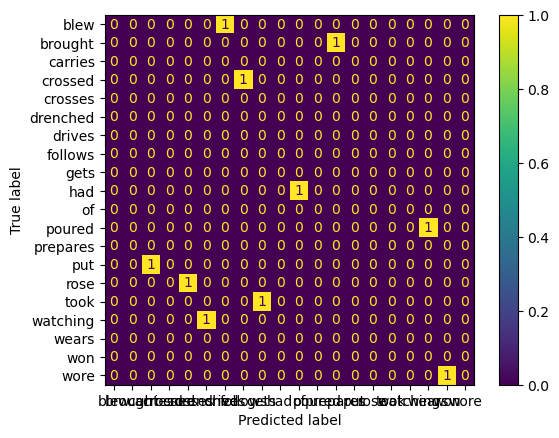

In [123]:
fig = plt.figure(figsize=(20, 10))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = full_list)
cm_display.plot()
plt.show(fig);

[Back to the TOC](#id0)

## Similarity Scores Between Actual and Predicted<a id="id8"></a>

In [18]:
nlp = spacy.load("en_core_web_md")
nlp

In [58]:
### https://spacy.io/usage/linguistic-features#vectors-similarity
### Word to vector for the list of true (actual) masked words
### Same goes for the predicted ones
### Can take the similarity scores for the each pair of words (true~predicted) 
### and the average for the list itself

for token in true:
    token_vec = nlp(token)
    print(token_vec.text, token_vec.has_vector, token_vec.vector_norm)

put True 83.36968839385139
put True 83.36968839385139
put True 83.36968839385139
put True 83.36968839385139
put True 83.36968839385139
brought True 42.49567754501403
brought True 42.49567754501403
brought True 42.49567754501403
brought True 42.49567754501403
brought True 42.49567754501403
crossed True 40.898532868973525
crossed True 40.898532868973525
crossed True 40.898532868973525
crossed True 40.898532868973525
crossed True 40.898532868973525
wore True 60.08197502541819
wore True 60.08197502541819
wore True 60.08197502541819
wore True 60.08197502541819
wore True 60.08197502541819
rose True 55.42226612796966
rose True 55.42226612796966
rose True 55.42226612796966
rose True 55.42226612796966
rose True 55.42226612796966
took True 75.74490168465488
took True 75.74490168465488
took True 75.74490168465488
took True 75.74490168465488
took True 75.74490168465488
watching True 38.47806242730999
watching True 38.47806242730999
watching True 38.47806242730999
watching True 38.47806242730999
wa

In [59]:
### https://spacy.io/usage/linguistic-features#vectors-similarity
### Word to vector for the list of true (actual) masked words
### Same goes for the predicted ones
### Can take the similarity scores for the each pair of words (true~predicted) 
### and the average for the list itself

for token in predicted:
    token_vec = nlp(token)
    print(token_vec.text, token_vec.has_vector, token_vec.vector_norm)

carries True 38.21381430958711
collects True 38.99000607382925
pulls True 41.61640585044665
handles True 38.71545642439109
opens True 45.99323766667351
prepares True 32.891856178682254
drinks True 44.290810394565796
orders True 52.63558541762223
delivers True 39.91978974146066
serves True 49.60738423913598
follows True 38.18315631044392
of True 120.90160624478666
crosses True 40.565298263988275
becomes True 48.04895472042354
along True 49.15293819155312
won True 105.3761175446047
wins True 58.233506304963086
received True 48.94463392974595
awarded True 52.47092608764651
earned True 49.700530175127696
crosses True 40.565298263988275
enters True 42.94517765433581
drains True 44.733481188016064
joins True 42.03864384986047
reaches True 41.23630535755728
gets True 56.91733648011779
drinks True 44.290810394565796
takes True 56.59037797680021
buys True 41.62466748200667
wants True 51.53075940521029
drenched True 34.480908610088946
fills True 40.14134761113116
filled True 45.07084587598318
fl

In [40]:
### Making a function to compare each word from the lists, get their similarity scores,
### and store the results as lists
def similarity_comparision(actual, pred):
    comparisons=[]
    true_word=[]
    predicted_word=[]
    for word in actual:
        true_word.append(word)
        word_vec = nlp(word)
        for item in pred:
            predicted_word.append(item)
            item_vec = nlp(item)
            comp = word_vec.similarity(item_vec)
            comparisons.append(comp)
    return comparisons, true_word, predicted_word

In [60]:
comparisons, true_word, predicted_word = similarity_comparision(true, predicted)

In [61]:
data_tuples = list(zip(true_word, predicted_word, comparisons))

In [62]:
comparison_df = pd.DataFrame(data_tuples, columns = ['True Word', 'Predicted Word', 'Similarity Scores'])


In [63]:
comparison_df.head(100)

,True Word,Predicted Word,Similarity Scores
0,put,carries,0.291859
1,put,collects,0.162198
2,put,pulls,0.521544
3,put,handles,0.296818
4,put,opens,0.253191
5,brought,prepares,0.241716
6,brought,drinks,0.124600
7,brought,orders,0.067452
8,brought,delivers,0.188906
9,brought,serves,0.124504


In [71]:
comparison_df.sort_values(by = 'Similarity Scores', ascending = False).head(100)

,True Word,Predicted Word,Similarity Scores
2,put,pulls,0.521544
27,took,takes,0.392028
34,watching,soaked,0.313376
30,watching,drenched,0.313376
32,watching,filled,0.311715
25,took,gets,0.303922
37,blew,blows,0.297296
3,put,handles,0.296818
46,poured,carries,0.291859
0,put,carries,0.291859


In [65]:
comparison_df.shape

(50, 3)

In [75]:
trained_comparison_df=pd.read_csv("TRAINED_dataframe.csv")

In [106]:
trained_comparison_df.rename(columns={' Trained Similarity Scores':'t_score', "Predicted Word":"p_word"}, inplace=True)

In [47]:
#trained_comparison_df.to_csv("TRAINED_dataframe.csv", index=False)

In [68]:
comparison_df.to_csv("UNtrained_dataframe.csv", index=False)

In [76]:
untrained_scores = list(comparison_df['Similarity Scores'])
Trained_Scores = list(trained_comparison_df['Similarity Scores'])

In [77]:
print(untrained_scores)
print(Trained_Scores)

[0.29185934135161956, 0.1621982665999373, 0.5215437336347828, 0.29681770138890834, 0.2531907490224241, 0.24171591550427593, 0.12459989399562306, 0.06745186401716625, 0.18890555384810923, 0.12450392038121705, 0.12412302707452444, 0.04713127512328141, 0.13611908625761052, 0.11906245975641969, 0.00571463249034238, 0.14891743891625112, 0.08828834334846221, 0.1822173118090343, 0.14482072457475192, 0.26452964067862633, 0.13611908625761052, 0.1692948247966768, 0.116601888728782, 0.1132015856132778, 0.24632367693973703, 0.30392187445467933, 0.12459989399562306, 0.39202841855484855, 0.2080964080759544, 0.2290770900548606, 0.3133757280981856, 0.2730777904664326, 0.3117152345383825, 0.15295129545734457, 0.3133757280981856, 0.27501887545366316, 0.22974171386512388, 0.29729607113142825, 0.04713127512328141, 0.1132015856132778, 0.04713127512328141, 0.20426168974732117, 0.1132015856132778, 0.23513703560357146, 0.20352788915560635, 0.2781737240095934, 0.29185934135161956, 0.05646003632127896, 0.118875

In [138]:
## making some practice Trained scores to see about stat test
def practice_scores(scores):
    practice_trained_scores = []
    for score in scores:
        score += 0.2
        practice_trained_scores.append(score)
    return practice_trained_scores

In [139]:
practice_trained_scores = practice_scores(untrained_scores)

In [78]:
### Will then run again with the trained BERT model, get the scores from that, and then compare whether or not
### they are different with a Man-Whitney test (maybe Chi-Square)
def mann_whitney_u_test(distribution_1, distribution_2):
    """
    Perform the Mann-Whitney U Test, comparing two different distributions.
    Args:
       distribution_1: List. 
       distribution_2: List.
    Outputs:
        u_statistic: Float. U statisitic for the test.
        p_value: Float.
    """
    u_statistic, p_value = stats.mannwhitneyu(distribution_1, distribution_2)
    return u_statistic, p_value


#### MAIN FUNCTION ####
#Perform the Mann-Whitney U Test on the two distributions: Sample input
mann_whitney_u_test(untrained_scores, Trained_Scores)

(1245.0, 0.9752451603405443)

Despite training the DistilBERT model on half of the novel, the lists of predicted words from the trained model were nearly identical to the list of predicted words from the untrained model. The null hypothesis is resoundingly confirmed.

In [107]:
frames = [comparison_df, trained_comparison_df]

combo_df = pd.concat(frames, axis=1)

In [128]:
combo_df.head()

,True Word,Predicted Word,Similarity Scores,True Word,p_word,t_score
0,put,carries,0.291859,put,carries,0.291859
1,put,collects,0.162198,put,collects,0.162198
2,put,pulls,0.521544,put,handles,0.296818
3,put,handles,0.296818,put,pulls,0.521544
4,put,opens,0.253191,put,steals,0.242032


In [129]:
combo_df.to_csv('combo_df.csv')

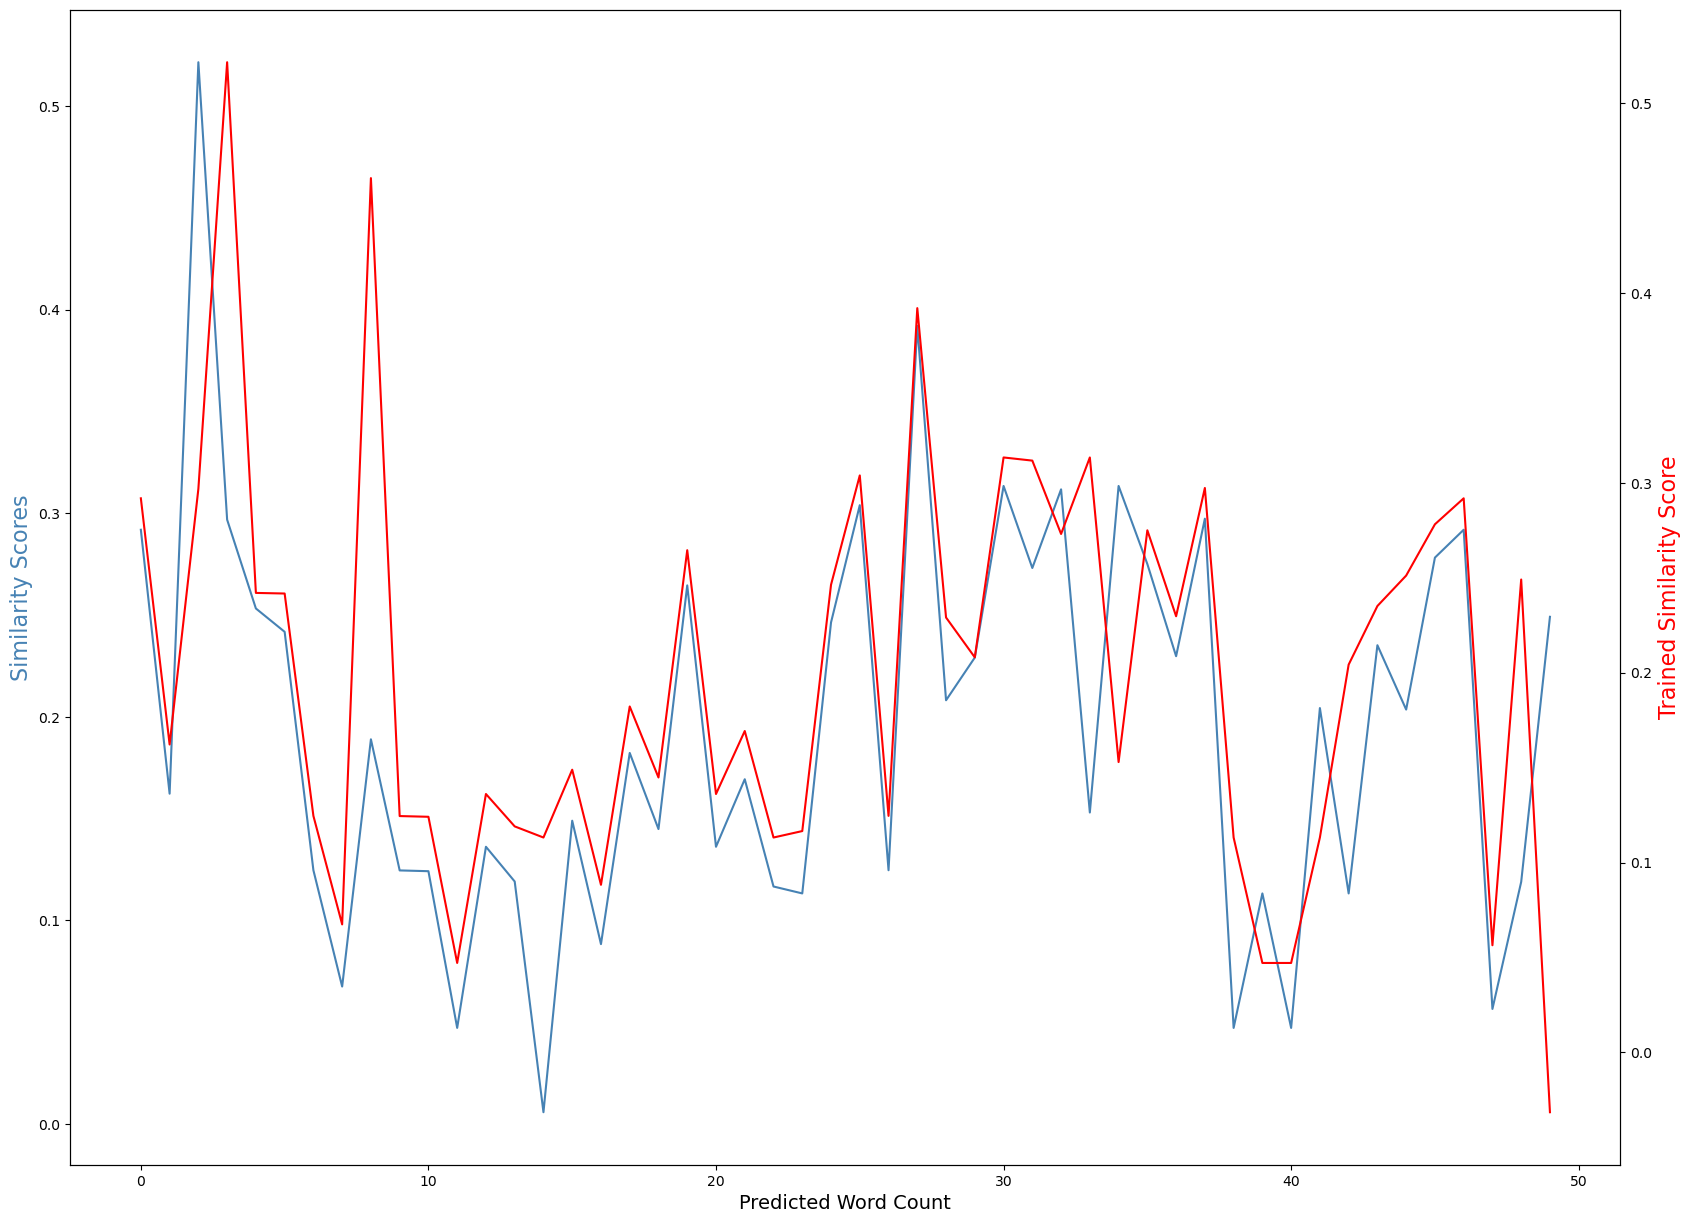

In [126]:
import matplotlib.pyplot as plt

#define colors to use
col1 = 'steelblue'
col2 = 'red'

#define subplots
fig,ax = plt.subplots(figsize=(20,15))


#add first line to plot
ax.plot(comparison_df.index, comparison_df['Similarity Scores'], color=col1)

#add x-axis label
ax.set_xlabel('Predicted Word Count', fontsize=14)

#add y-axis label
ax.set_ylabel('Similarity Scores', color=col1, fontsize=16)

#define second y-axis that shares x-axis with current plot
ax2 = ax.twinx()

#add second line to plot
ax2.plot(trained_comparison_df.index, trained_comparison_df['t_score'], color=col2)

#add second y-axis label
ax2.set_ylabel('Trained Similarity Score', color=col2, fontsize=16)
plt.savefig('Trained vs. Untrained Model.png', format='png')